<a href="https://colab.research.google.com/github/zhestyatsky/mipt-opt-project/blob/dev/src/spider_boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import sys

In [0]:
def gradient_descent(train_dataset, batch_size, model, loss, regularizer, lr, n_epochs):
    total_loss = np.zeros(n_epochs)   
  
    x_full, y_full = train_dataset.data, train_dataset.targets
    batch_train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        if epoch % 20 == 0:
            print(f'epoch: {epoch}', file=sys.stderr)
  
        for x_batch, y_batch in batch_train_loader:
            # Optimize with batch gradient
            opt.zero_grad()
            y_pred = model(x_batch)
            batch_loss = loss(y_pred, y_batch) + regularizer(model.parameters())
            batch_loss.backward()
            opt.step()
    
        # Save loss at the end of the epoch
        y_pred = model(x_full)
        total_loss[epoch] = loss(y_pred, y_full).item() + regularizer(model.parameters()).item()
    return total_loss

In [0]:
def spider_boost(train_dataset, batch_size, model, loss, regularizer, lr, n_epochs):
    total_loss = np.zeros(n_epochs)
    
    x_full, y_full = train_dataset.data, train_dataset.targets
    batch_train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    model_prev = copy.deepcopy(model)
    if torch.cuda.is_available():
        model_prev = model_prev.cuda()

    opt = torch.optim.SGD(model.parameters(), lr=lr)
    opt_prev = torch.optim.SGD(model_prev.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        if epoch % 20 == 0:
            print(f'epoch: {epoch}', file=sys.stderr)

        # Calculate full gradient first
        opt.zero_grad()
        y_pred = model(x_full)
        main_loss = loss(y_pred, y_full) + regularizer(model.parameters())
        main_loss.backward()
        
        # Saving current model weights and zero grad them
        for param, param_prev in zip(model.parameters(), model_prev.parameters()):
            param_prev.data = param.data.clone().detach()
        opt_prev.zero_grad()
        
        # Optimize
        opt.step()
        
        for x_batch, y_batch in batch_train_loader:
            # Add current state gradients
            y_pred = model(x_batch)
            batch_loss = loss(y_pred, y_batch) + regularizer(model.parameters())
            batch_loss.backward()
            
            # Calculate previous state gradients
            y_pred_prev = model_prev(x_batch)
            batch_loss_prev = loss(y_pred_prev, y_batch)
            batch_loss_prev.backward()

            # Subtract previous state gradients
            for param, param_prev in zip(model.parameters(), model_prev.parameters()):
                param.grad.data -= param_prev.grad.data
                param_prev.data = param.data.clone().detach()
            opt_prev.zero_grad()
            
            # Optimize
            opt.step()
        
        # Save loss at the end of the epoch
        y_pred = model(x_full)
        total_loss[epoch] = loss(y_pred, y_full).item() + regularizer(model.parameters()).item()
    return total_loss

In [0]:
class DatasetWrapper(Dataset):
    def __init__(self, dataset):
        self.data, self.targets = dataset.data, dataset.targets
        
        self.data = self.data.float().view(len(self.data), -1)
        if torch.cuda.is_available():
            self.data = self.data.cuda()
            self.targets = self.targets.cuda()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

train_dataset = dsets.MNIST(root='~/.pytorch/MNIST_data/', train=True, transform=transforms.ToTensor(), download=True)
train_dataset = DatasetWrapper(train_dataset)

In [0]:
class CustomModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomModel, self).__init__()
        self.conv1 = torch.nn.Linear(input_dim, 28)
        self.conv2 = torch.nn.Linear(28, output_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        outputs = torch.sigmoid(self.conv2(x))
        return outputs
    
gd_model = CustomModel(784, 10)
sb_model = copy.deepcopy(gd_model)

if torch.cuda.is_available():
    gd_model = gd_model.cuda()
    sb_model = sb_model.cuda()

In [0]:
loss = torch.nn.CrossEntropyLoss().cuda()
def regularizer(parameters, alpha=0.1):
    value = 0.0
    for p in parameters:
        value += alpha * (p**2 / (1 + p**2)).sum()
    return value

In [0]:
batch_size = 2048
learning_rate = 0.001
n_epochs = 100

In [17]:
gd_total_loss = gradient_descent(train_dataset, batch_size, gd_model, loss, regularizer, learning_rate, n_epochs)
sb_total_loss = spider_boost(train_dataset, batch_size, sb_model, loss, regularizer, learning_rate, n_epochs)

epoch: 0
epoch: 20
epoch: 40
epoch: 60
epoch: 80
epoch: 0
epoch: 20
epoch: 40
epoch: 60
epoch: 80


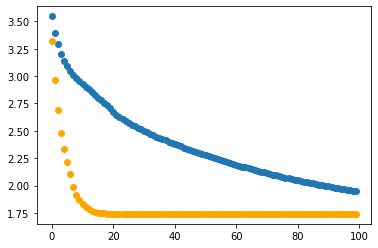

In [18]:
plt.scatter(np.arange(n_epochs), gd_total_loss)
plt.scatter(np.arange(n_epochs), sb_total_loss, color='orange')
plt.show()